<a href="https://colab.research.google.com/github/ricglz/CE888_activities/blob/main/assignment/Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normally constant aspects (doesn't require as much config)

## Install dependencies

---

In [ ]:
!pip --quiet install torch torchvision pytorch-lightning patool \
    git+https://github.com/rwightman/pytorch-image-models

In [ ]:
from zipfile import ZipFile
from tqdm import tqdm
from os import path, mkdir
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from patoolib import extract_archive

import pytorch_lightning as pl
import pytorch_lightning.callbacks as pl_callbacks
from pytorch_lightning.utilities import xla_device
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.tuner.lr_finder import lr_find
from pytorch_lightning.metrics import Accuracy, ConfusionMatrix, \
                                      MetricCollection, F1

from torch import cuda, sigmoid, stack
from torch.optim import Adam, AdamW, SGD
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, random_split
from torch.nn import BCEWithLogitsLoss, ModuleDict
from torch.nn.modules.batchnorm import _BatchNorm

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

## Preparations

---


Before we begin, lets mount the google drive to later on read information from it:

In [ ]:
try:
    from google.colab import drive
    in_colab = True
except ImportError:
    in_colab = False

In [ ]:
def unzip_file(zip_path, dest_path):
    with ZipFile(zip_path, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting '):
            zf.extract(member, dest_path)

In [ ]:
def unrar_files(tar_dir_path, dest_dir):
    if not path.exists(dest_dir):
        mkdir(dest_dir)
    for dataset in ('Test', 'Training'):
        tar_path = path.join(tar_dir_path, f'{dataset}.tar')
        dest_folder = path.join(dest_dir, dataset)
        if path.exists(dest_folder):
            continue
        mkdir(dest_folder)
        extract_archive(tar_path, outdir=dest_folder)

In [ ]:
def get_data_dir():
    kaggle_path = '../input/ce888-dataset'
    if path.exists(kaggle_path):
        dest_dir = './data'
        unrar_files(kaggle_path, dest_dir)
        return dest_dir

    general_dir = '.'
    data_dir = general_dir + '/Flame'
    if in_colab and not path.exists(data_dir):
        drive_path = '/content/gdrive'
        drive.mount(drive_path, force_remount=False)
        zip_path = path.join(
            drive_path, 'MyDrive/Essex/Datasets/zipped/Flame.zip')
        unzip_file(zip_path, general_dir)
    return data_dir

In [ ]:
def get_model_dir():
    return '/content/gdrive/MyDrive/Models/Lightning' if in_colab \
           else './Models'

Next we will set the seeds in everything to make this as deterministic as possible

In [ ]:
seed = 42
pl.seed_everything(seed)

Global seed set to 42


42

## Create datamodule

----

A datamodule is a module that provides us _lightning_ to be able to structure our datadependencies in a more modular way

In this case we will also declare transformations like the resize and the normalization. The normalization used are [the mean and std of the ImageNet dataset](https://github.com/rwightman/pytorch-image-models/blob/master/timm/data/constants.py)

In [ ]:
# 292 steps

DEFAULT_BATCH_SIZE = 32
DEFAULT_IMAGE_SIZE = (224, 224)
STEPS = 1875

class FlameDataModule(pl.LightningDataModule):
    def __init__(
            self,
            batch_size=DEFAULT_BATCH_SIZE,
            image_size=DEFAULT_IMAGE_SIZE
        ):
        super().__init__()
        self.batch_size = batch_size
        resize = T.Resize(image_size)
        normalize = T.Normalize([0.485, 0.456, 0.406], 
                                [0.229, 0.224, 0.225])
        toTensor = T.ToTensor()
        self.train_transforms = T.Compose([
            resize,
            T.ColorJitter(brightness=0.1, contrast=0.1),
            T.RandomRotation(degrees=5),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            toTensor,
            normalize
        ])
        self.transforms = T.Compose([resize, toTensor, normalize])

    def prepare_data(self):
        self.data_dir = get_data_dir()

    @staticmethod
    def split_dataset(dataset):
        train_val_length = len(dataset)
        val_length = train_val_length // 5
        train_length = train_val_length - val_length
        return random_split(dataset, [train_length, val_length])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            training_dir = path.join(self.data_dir, 'Training')
            full_dataset = ImageFolder(training_dir, self.train_transforms)
            self.train_ds, self.val_ds = self.split_dataset(full_dataset)
            self.val_ds.transforms = self.transforms
        elif stage == 'test' or stage is None:
            testing_dir = path.join(self.data_dir, 'Test')
            self.test_ds = ImageFolder(testing_dir, transform=self.transforms)

    def _general_dataloader(self, dataset, shuffle=False):
        return DataLoader(
            dataset, batch_size=self.batch_size, shuffle=shuffle,
            num_workers=8, drop_last=True, pin_memory=True)

    def train_dataloader(self):
        return self._general_dataloader(self.train_ds, shuffle=True)

    def val_dataloader(self):
        return self._general_dataloader(self.val_ds)

    def test_dataloader(self):
        return self._general_dataloader(self.test_ds)

In [ ]:
datamodule = FlameDataModule()

## Helper functions

---

In [ ]:
def get_cm_figure(cm):
    df_cm = DataFrame(cm, index=range(len(cm)), columns=range(len(cm)))
    fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    plt.close(fig_)

    return fig_

# Model 

---

In [ ]:
class PretrainedModel(pl.LightningModule):
    def __init__(
        self, name='rexnet_200', lr=1e-3, epochs=10, steps_per_epoch=100,
        weight_decay=1e-2, freeze=False,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.model = timm.create_model(name, pretrained=True,
                                       num_classes=1, drop_rate=0.5)
        if freeze:
            self.freeze()
            pl_callbacks.BaseFinetuning.make_trainable(self.model.get_classifier())

        self.criterion = BCEWithLogitsLoss()
        self.metrics = self.build_metrics()

    @staticmethod
    def build_metrics():
        general_metrics = [
            Accuracy(compute_on_step=False),
            F1(num_classes=2, compute_on_step=False)
        ]
        metric = MetricCollection(general_metrics)
        return ModuleDict({
            'test_metrics': MetricCollection(general_metrics + [
                ConfusionMatrix(compute_on_step=False, num_classes=2),
            ]),
            'train_metrics': metric.clone(),
            'val_metrics': metric.clone(),
        })

    def forward(self, x):
        return self.model(x).squeeze(-1)
    
    def predict(self, x):
        proba = sigmoid(self(x))
        return (proba > 0.5).byte()

    # Configurations
    def configure_optimizers(self):
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        hparams = self.hparams
        optimizer = AdamW(
            parameters, lr=hparams.lr, weight_decay=hparams.weight_decay)
        scheduler = OneCycleLR(
            optimizer, max_lr=hparams.lr, epochs=hparams.epochs,
            steps_per_epoch=hparams.steps_per_epoch)
        scheduler_dict = {'scheduler': scheduler, 'interval': 'step'}
        return [optimizer], [scheduler_dict]

    # Steps
    def _get_dataset_metrics(self, dataset):
        return self.metrics[f'{dataset}_metrics']

    def _update_metrics(self, y_hat, y, dataset):
        proba = sigmoid(y_hat)
        self._get_dataset_metrics(dataset).update(proba, y)

    def _on_step(self, batch, dataset):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.float())
        self._update_metrics(y_hat, y, dataset)
        self.log(f'{dataset}_loss', loss, prog_bar=True)
        return loss

    def _on_end_epochs(self, outputs, dataset):
        cm_label = f'{dataset}_cm'
        labels = [f'{dataset}_acc', f'{dataset}_f1']
        if dataset == 'test':
            labels.append(cm_label)

        metrics = self._get_dataset_metrics(dataset)
        metrics_values = metrics.compute().values()
        score = 0
        for label, value in zip(labels, metrics_values):
            if label[:3] == 'val':
                score += value.item()
            if label == cm_label:
                fig = get_cm_figure(value.cpu().numpy())
                self.logger.experiment.add_figure(
                    label, fig, self.current_epoch)
            else:
                self.log(label, value)
        if dataset == 'val':
            self.log('val_score', score / len(labels))
        metrics.reset()

    def training_step(self, batch, batch_idx):
        return self._on_step(batch, 'train')
    
    def training_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self._on_step(batch, 'val')

    def validation_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'val')

    def test_step(self, batch, batch_idx):
        return self._on_step(batch, 'test')

    def test_epoch_end(self, outputs):
        self._on_end_epochs(outputs, 'test')

# Trainer

---

In [ ]:
def get_accelerator():
    tpu_device_exists = xla_device.XLADeviceUtils().tpu_device_exists()
    has_gpu = cuda.is_available()

    return {'tpu_cores': 8} if tpu_device_exists else \
           {'gpus': cuda.device_count()} if has_gpu else {}

In [ ]:
production_mode = True

def get_dev_testing_args():
    return {} if production_mode else \
        { 'limit_val_batches' : 3, 'limit_train_batches': 3, 'max_epochs': 6}

In [ ]:
max_epochs = 40

def create_trainer(model_name, **kwargs):
    accelerator = get_accelerator()
    dev_testing_args = get_dev_testing_args()
    return pl.Trainer(
        max_epochs=max_epochs, progress_bar_refresh_rate=2, deterministic=True,
        benchmark=True, **accelerator, **kwargs, **dev_testing_args)

# Function for tuning the learning rate and find the best one

---

In [ ]:
def plot_tuner_model(model_name, weight_decay=0.2):
    trainer = create_trainer(model_name, auto_lr_find=True)
    model = PretrainedModel(model_name, freeze=True, weight_decay=weight_decay)
    finder = lr_find(
        trainer, model, datamodule=datamodule, min_lr=2e-4, max_lr=11,
        num_training=500)
    fig = finder.plot(suggest=True)
    fig.suptitle(f'{model_name} - LR')
    best_lr = f'{finder.results["lr"][finder._optimal_idx]:.4e}'
    print(model_name, best_lr)
    cuda.empty_cache()
    # plt.show()

# Tuning results

---

In [ ]:
models = [
  'gernet_m',
  'repvgg_b0',
  'rexnet_200',
  'tf_efficientnet_b4',
  'cspresnext50',
  'densenet201',
  'ecaresnet101d_pruned',
  'gluon_inception_v3',
  'gluon_resnet34_v1b',
  'regnety_040',
  'res2next50',
  'resnest26d',
  'skresnet34',
  'xception',
  'dla60x',
  'dpn68b',
  'ese_vovnet39b',
  'hrnet_w18',
  'seresnext26t_32x4d'
]


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ByobNet           | 18.6 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
2.6 K     Trainable params
18.6 M    Non-trainable params
18.6 M    Total params
74.338    Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


gernet_m 5.3415e-04


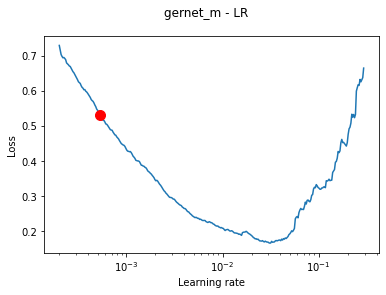

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ByobNet           | 14.5 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
1.3 K     Trainable params
14.5 M    Non-trainable params
14.5 M    Total params
58.153    Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


repvgg_b0 3.1632e-04


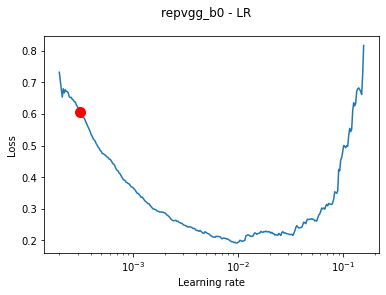

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ReXNetV1          | 13.8 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
2.6 K     Trainable params
13.8 M    Non-trainable params
13.8 M    Total params
55.233    Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


rexnet_200 3.0949e-04


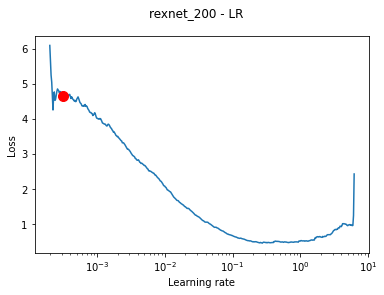

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name      | Type              | Params
------------------------------------------------
0 | model     | EfficientNet      | 17.6 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | metrics   | ModuleDict        | 0     
------------------------------------------------
1.8 K     Trainable params
17.5 M    Non-trainable params
17.6 M    Total params
70.202    Total estimated model params size (MB)


LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


tf_efficientnet_b4 3.0949e-04


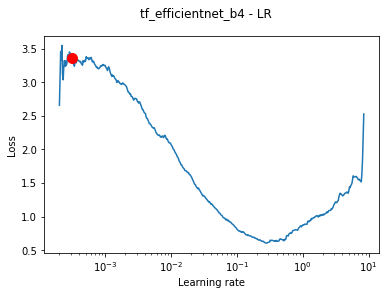

In [ ]:
for model in models[:4]:
    plot_tuner_model(model)
    plt.show()